In [3]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OSX 3D keypoints

In [4]:
# Load 3D joint outputs from OSX (num_videos x num_frames x num_joints (=65) x num_coordinates(=3))
# Each video is flattened to a single row of entry

pickle_path = '/home/ubuntu/OSX/output/STS_test6/log/'
joint_3d_out_o = np.array(pickle.load(open(os.path.join(pickle_path, "joint_3d_out.p"), "rb")))
video_list_3d = pickle.load(open(os.path.join(pickle_path, "video_list_3d.p"), "rb"))

num_samples = joint_3d_out_o.shape[0]
joint_3d_out = joint_3d_out_o.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
joint_3d_out_pd = pd.DataFrame(joint_3d_out)
joint_3d_out_pd.insert(0, 'subjectid', video_list_3d)

print(joint_3d_out_pd.shape)
joint_3d_out_pd


(349, 160876)


,subjectid,0,1,2,3,4,5,6,7,8,...,160865,160866,160867,160868,160869,160870,160871,160872,160873,160874
0,5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,bqTsXpKl,6.932800,7.879572,8.000360,7.389689,8.474448,7.839578,6.268540,8.225052,8.360550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [5]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [6]:
# join the dataframes by subjectId 
df_join = joint_3d_out_pd.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
print(df_join.shape)
df_join

(349, 160876)


,0,1,2,3,4,5,6,7,8,9,...,160866,160867,160868,160869,160870,160871,160872,160873,160874,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,4.190158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,8.113709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,5.486351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,8.808135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,8.503104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,5.504666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,8.528066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,8.484241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 349 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  # 349
print(df_join['OA_check'].sum())    # 21
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  # 279
print(train_data['OA_check'].sum())    # 17

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count())  # 35
print(val_data['OA_check'].sum())    # 2

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count())  # 35
print(test_data['OA_check'].sum())    # 2

349
21
279
17
35
2
35
2


#### Normalization
Skipped normalization as the data is already within a narrow range. Also, later columns often have very few data points (e.g. 1) making normalization difficult.

#### Create dataloaders

In [10]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [11]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 160875]) torch.Size([64])
tensor([[6.8850, 7.9444, 8.0010,  ..., 0.0000, 0.0000, 0.0000],
        [4.5307, 7.9545, 8.0006,  ..., 0.0000, 0.0000, 0.0000],
        [4.9257, 8.0956, 8.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.3493, 7.4637, 8.0006,  ..., 0.0000, 0.0000, 0.0000],
        [5.2183, 7.9840, 8.0002,  ..., 0.0000, 0.0000, 0.0000],
        [7.1643, 8.2052, 8.0003,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


#### Create a manually curated data set
Skipped

#### Create dataloaders with upsampling 

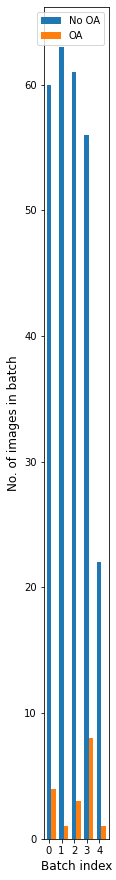

Avg Proportion of No OA per batch: 5.24
Avg Proportion of OA per batch: 0.34
Num. unique images seen: 279/279


In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

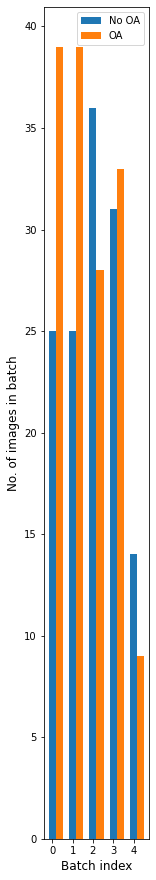

Avg Proportion of No OA per batch: 2.62
Avg Proportion of OA per batch: 2.96
Num. unique images seen: 117/279


In [13]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with unnormalized inputs, no oversampling

In [ ]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 15.1538, train_acc = 86.0215, val_acc = 94.2857, train_pos = 7.8853, val_pos = 0.0000
Epoch 1, loss = 0.0000, train_acc = 93.9068, val_acc = 94.2857, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 1.8974, train_acc = 93.5484, val_acc = 91.4286, train_pos = 1.7921, val_pos = 2.8571
Epoch 3, loss = 0.9992, train_acc = 87.0968, val_acc = 94.2857, train_pos = 10.3943, val_pos = 0.0000
Epoch 4, loss = 0.7799, train_acc = 93.1900, val_acc = 62.8571, train_pos = 2.1505, val_pos = 37.1429
Epoch 5, loss = 0.3463, train_acc = 89.6057, val_acc = 91.4286, train_pos = 5.0179, val_pos = 14.2857
Epoch 6, loss = 0.2221, train_acc = 91.3978, val_acc = 82.8571, train_pos = 2.5090, val_pos = 11.4286
Epoch 7, loss = 0.6301, train_acc = 91.3978, val_acc = 91.4286, train_pos = 4.6595, val_pos = 2.8571
Epoch 8, loss = 1.0231, train_acc = 91.0394, val_acc = 91.4286, train_pos = 6.4516, val_pos = 2.8571
Epoch 9, loss = 0.0011, train_acc = 93.9068, val_acc = 94.2857, train_pos = 5.7348, va

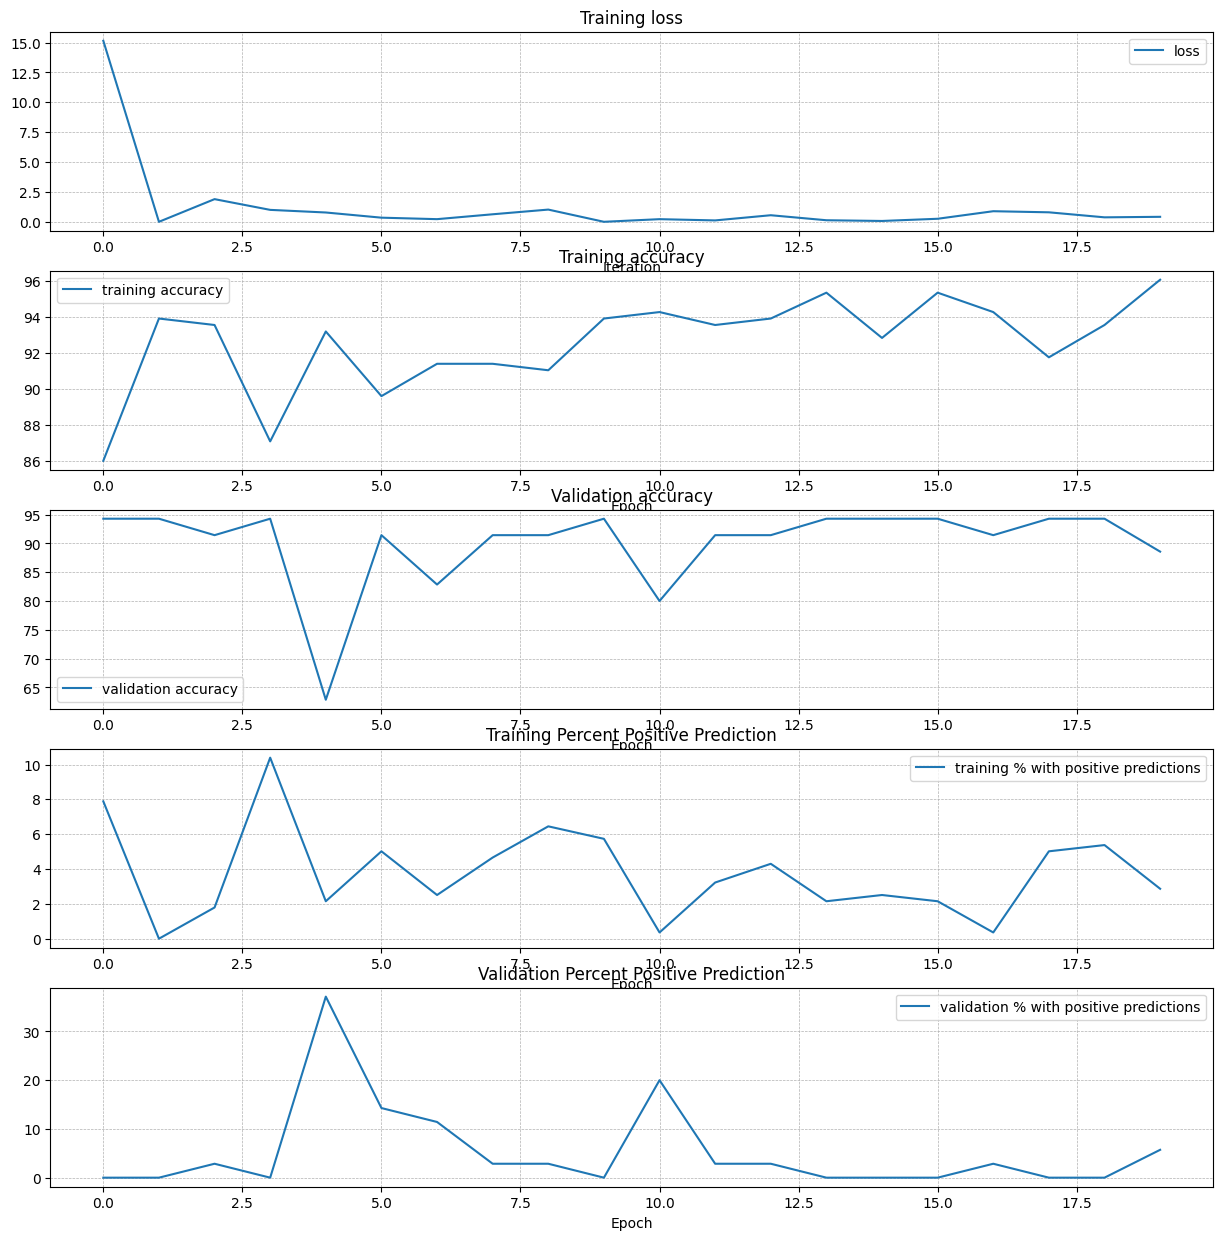

In [14]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, with oversampling

In [13]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

KeyboardInterrupt: 

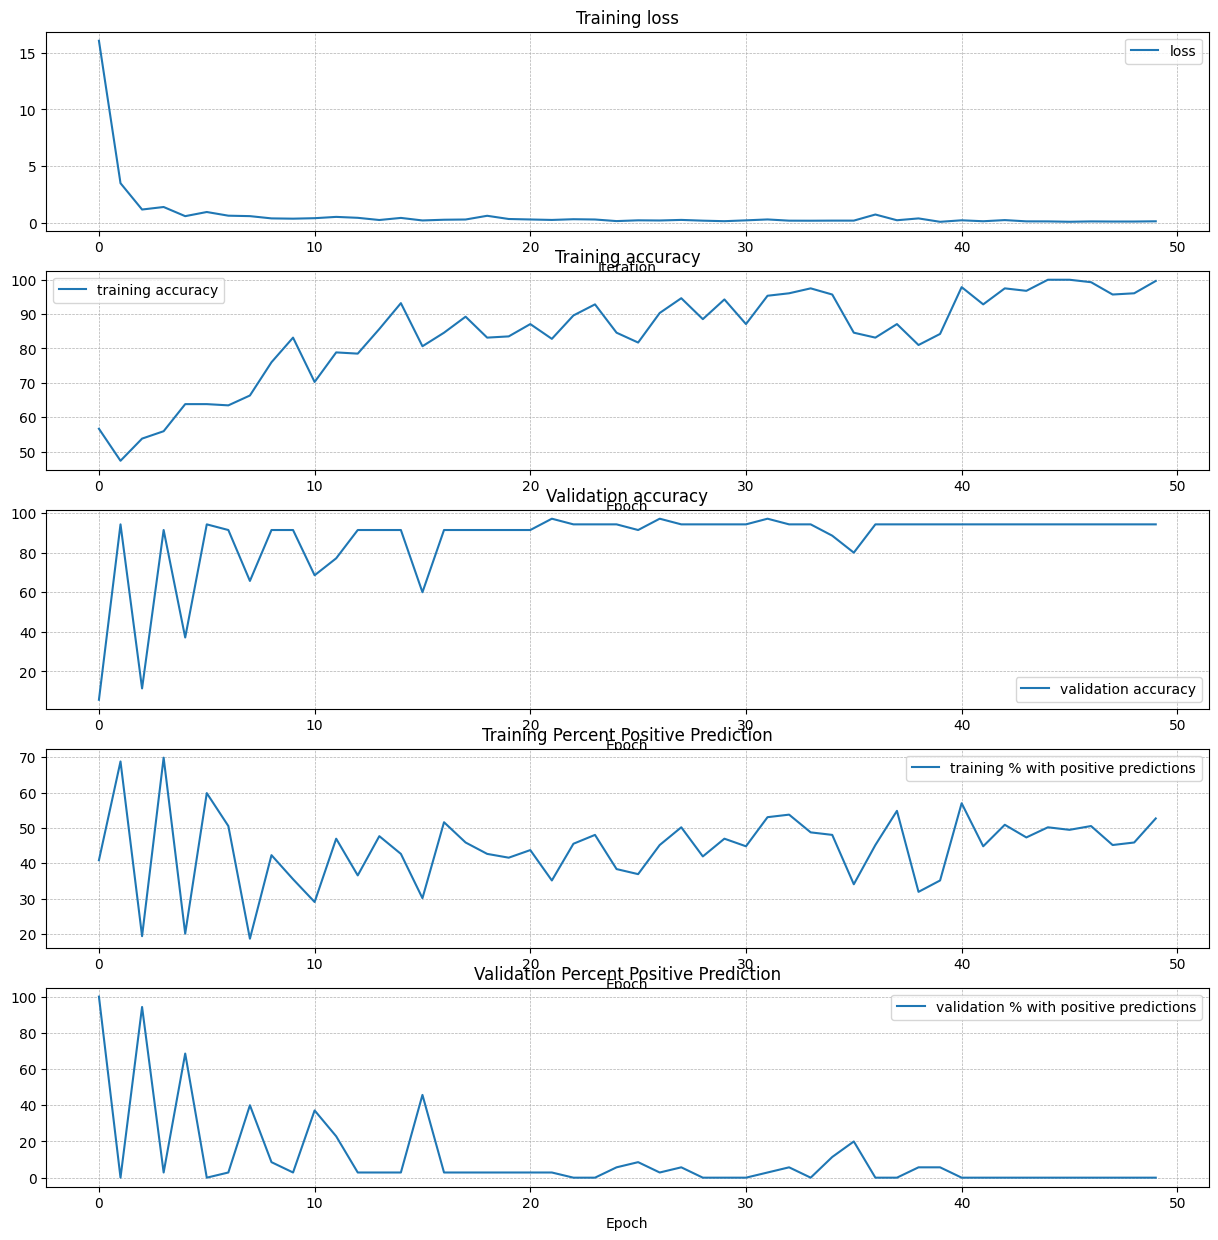

In [25]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, with weighted loss

In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos, best_val, best_model = train_and_get_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

pickle.dump(best_model, open('../models/OSX_weighted_loss', 'wb'))

Epoch 0, loss = 65.0183, train_acc = 45.8781, val_acc = 77.1429, train_pos = 50.1792, val_pos = 17.1429
Epoch 1, loss = 14.2159, train_acc = 30.4659, val_acc = 91.4286, train_pos = 74.1935, val_pos = 2.8571
Epoch 2, loss = 20.8185, train_acc = 81.7204, val_acc = 5.7143, train_pos = 15.0538, val_pos = 100.0000
Epoch 3, loss = 0.1347, train_acc = 28.6738, val_acc = 91.4286, train_pos = 75.9857, val_pos = 2.8571
Epoch 4, loss = 18.4901, train_acc = 87.0968, val_acc = 68.5714, train_pos = 10.3943, val_pos = 25.7143
Epoch 5, loss = 9.8396, train_acc = 44.0860, val_acc = 91.4286, train_pos = 61.2903, val_pos = 2.8571
Epoch 6, loss = 5.2366, train_acc = 83.8710, val_acc = 20.0000, train_pos = 15.7706, val_pos = 85.7143
Epoch 7, loss = 2.7331, train_acc = 65.9498, val_acc = 14.2857, train_pos = 33.6918, val_pos = 91.4286
Epoch 8, loss = 0.5186, train_acc = 60.5735, val_acc = 77.1429, train_pos = 41.2186, val_pos = 22.8571
Epoch 9, loss = 0.2365, train_acc = 67.3835, val_acc = 94.2857, train_po

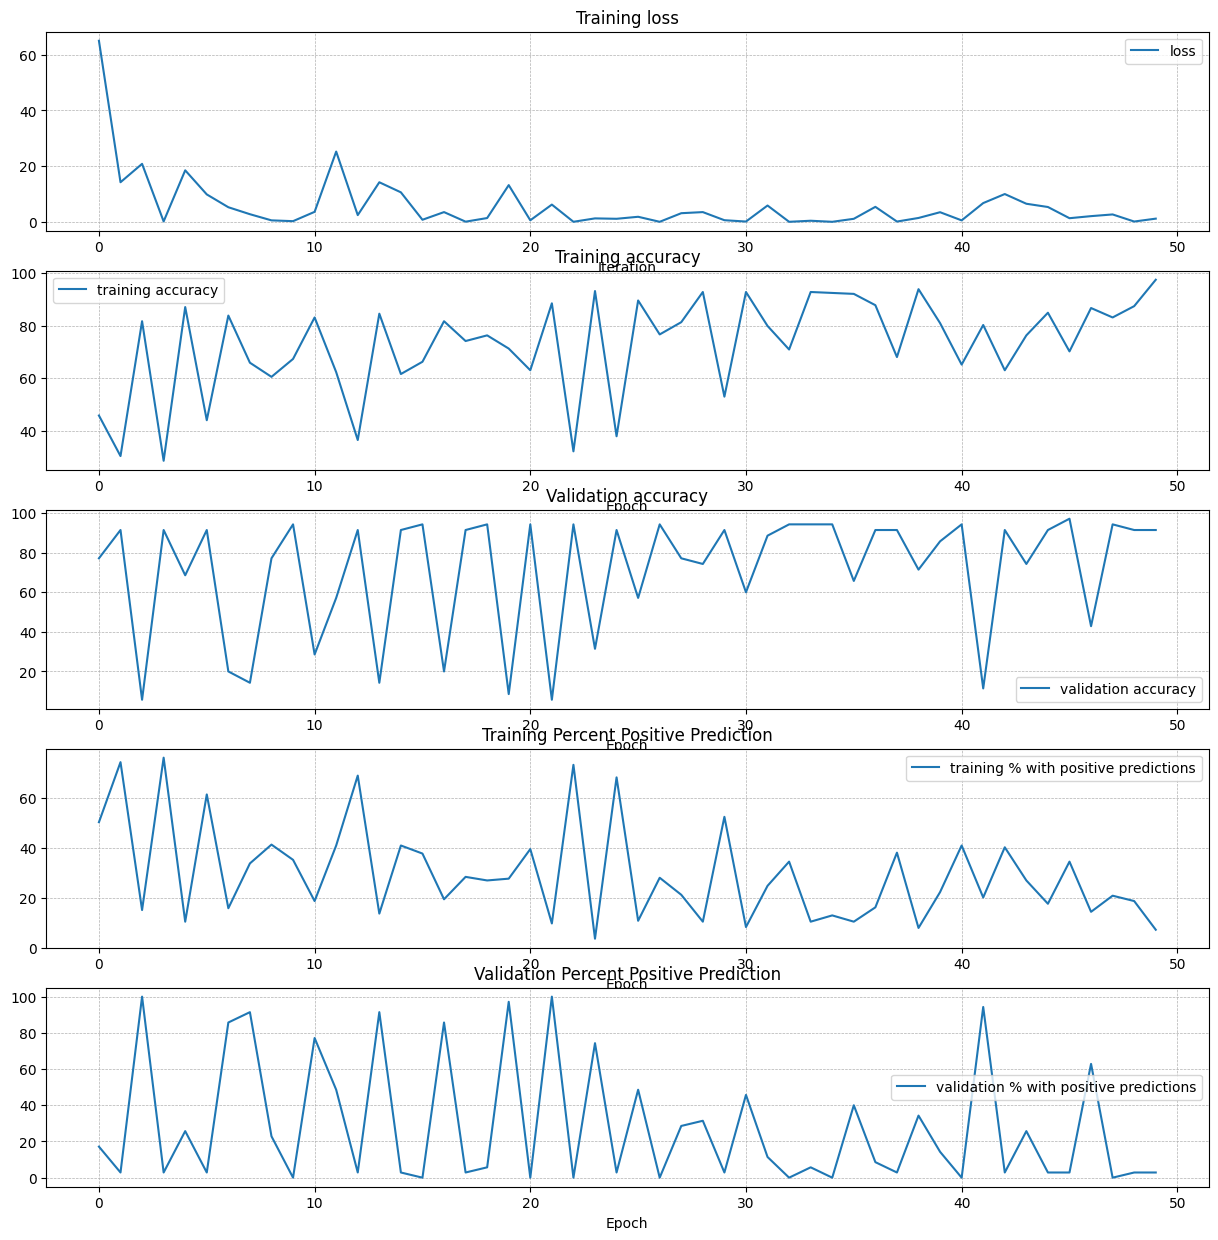

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Create Saliency Map

In [14]:
best_model = pickle.load(open('../models/OSX_weighted_loss_lr00001', 'rb'))

In [15]:
acc, percent_pos, f1_score_avg = check_accuracy(loader_val, best_model)
print("val", acc, percent_pos)
acc, percent_pos, f1_score_avg = check_accuracy(loader_test, best_model)
print("test", acc, percent_pos)

0.9714285714285714 0.02857142857142857
0.8571428571428571 0.08571428571428572


In [16]:
def compute_saliency_maps(x, y, num_samples_pos, num_samples_neg, model):
    """
    - X: Input; Tensor of shape (N, D)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained model used to generate the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, D) giving the saliency maps for the inputs.
    """
    model.eval()
    x.requires_grad_()

    saliency = None

    scores = model(x).squeeze(dim=1)
    weight = torch.as_tensor(num_samples_neg / num_samples_pos, dtype=torch.float)
    BCEWithLogitsLoss = nn.BCEWithLogitsLoss(pos_weight=weight)
    loss = BCEWithLogitsLoss(scores, y)
    loss.backward()
    saliency = x.grad

    return saliency

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
x = torch.as_tensor(train_data.iloc[:, :-1].values, dtype=torch.float).to(device=device)
y = torch.as_tensor(train_data.iloc[:, -1].values, dtype=torch.float).to(device=device)
saliency = compute_saliency_maps(x, y, num_samples_pos, num_samples_neg, best_model)

RuntimeError: CUDA out of memory. Tried to allocate 1.20 GiB (GPU 0; 14.76 GiB total capacity; 1.54 GiB already allocated; 1.09 GiB free; 1.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

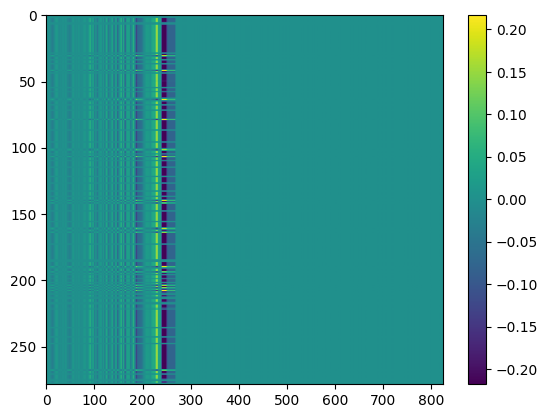

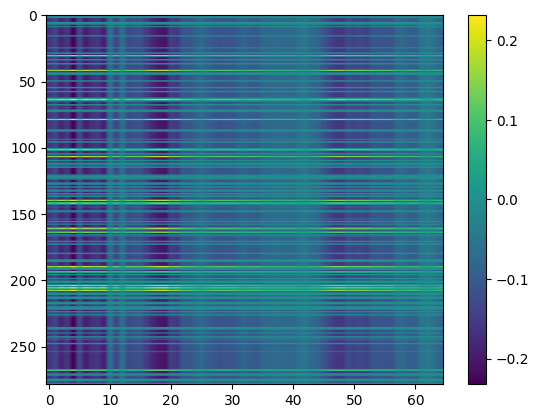

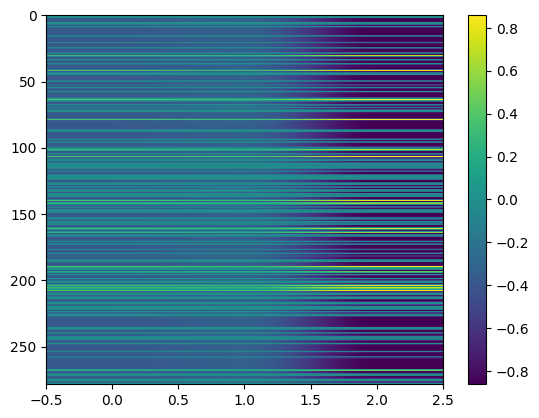

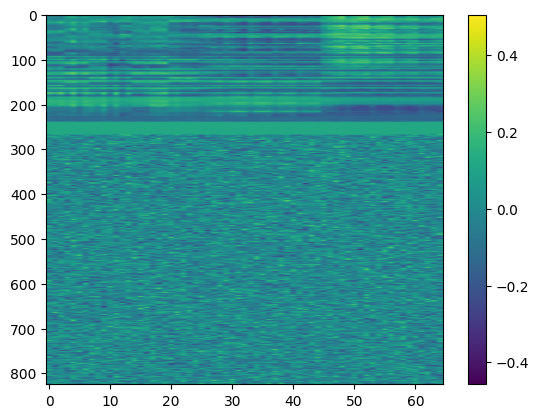

In [107]:
_, F, J, D = joint_3d_out_o.shape
N = saliency.shape[0]
saliency_NF = saliency.view((N, F, J, D)).mean(dim=(2, 3))
saliency_NF = nn.functional.normalize(saliency_NF, dim=1).cpu()
saliency_NJ = saliency.view((N, F, J, D)).mean(dim=(1, 3))
saliency_NJ = nn.functional.normalize(saliency_NJ, dim=1).cpu()
saliency_ND = saliency.view((N, F, J, D)).mean(dim=(1, 2))
saliency_ND = nn.functional.normalize(saliency_ND, dim=1).cpu()
saliency_FJ = saliency.view((N, F, J, D)).mean(dim=(0, 3))
saliency_FJ = nn.functional.normalize(saliency_FJ, dim=1).cpu()


plt.imshow(saliency_NF, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(saliency_NJ, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(saliency_ND, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(saliency_FJ, aspect='auto')
plt.colorbar()
plt.show()

In [26]:
joints_name = \
['Pelvis', 'L_Hip', 'R_Hip', 'L_Knee', 'R_Knee', 'L_Ankle', 'R_Ankle', 'Neck', 'L_Shoulder', 'R_Shoulder', 'L_Elbow', 'R_Elbow', 'L_Wrist', 'R_Wrist', 'L_Big_toe', 'L_Small_toe', 'L_Heel', 'R_Big_toe', 'R_Small_toe', 'R_Heel', 'L_Ear', 'R_Ear', 'L_Eye', 'R_Eye', 'Nose', # body joints
'L_Thumb_1', 'L_Thumb_2', 'L_Thumb_3', 'L_Thumb_4', 'L_Index_1', 'L_Index_2', 'L_Index_3', 'L_Index_4', 'L_Middle_1', 'L_Middle_2', 'L_Middle_3', 'L_Middle_4', 'L_Ring_1', 'L_Ring_2', 'L_Ring_3', 'L_Ring_4', 'L_Pinky_1', 'L_Pinky_2', 'L_Pinky_3', 'L_Pinky_4', # left hand joints
'R_Thumb_1', 'R_Thumb_2', 'R_Thumb_3', 'R_Thumb_4', 'R_Index_1', 'R_Index_2', 'R_Index_3', 'R_Index_4', 'R_Middle_1', 'R_Middle_2', 'R_Middle_3', 'R_Middle_4', 'R_Ring_1', 'R_Ring_2', 'R_Ring_3', 'R_Ring_4', 'R_Pinky_1', 'R_Pinky_2', 'R_Pinky_3', 'R_Pinky_4'] # right hand joints

saliency_J = saliency.view((N, F, J, D)).mean(dim=(0, 1, 3)).cpu()
joint_saliency = pd.DataFrame(saliency_J.numpy() * 10 ** 7)
joint_saliency.insert(0, 'joint_names', joints_name)
display(joint_saliency.to_string())

'    joint_names         0\n0        Pelvis  0.433894\n1         L_Hip  0.357198\n2         R_Hip  0.487022\n3        L_Knee  0.412344\n4        R_Knee  0.601404\n5       L_Ankle  0.342382\n6       R_Ankle  0.513417\n7          Neck  0.439664\n8    L_Shoulder  0.413531\n9    R_Shoulder  0.507529\n10      L_Elbow  0.164299\n11      R_Elbow  0.356632\n12      L_Wrist  0.163785\n13      R_Wrist  0.339046\n14    L_Big_toe  0.312445\n15  L_Small_toe  0.310045\n16       L_Heel  0.394291\n17    R_Big_toe  0.480013\n18  R_Small_toe  0.524113\n19       R_Heel  0.540183\n20        L_Ear  0.386892\n21        R_Ear  0.411240\n22        L_Eye  0.281875\n23        R_Eye  0.289364\n24         Nose  0.238349\n25    L_Thumb_1  0.190436\n26    L_Thumb_2  0.245580\n27    L_Thumb_3  0.284684\n28    L_Thumb_4  0.302277\n29    L_Index_1  0.281785\n30    L_Index_2  0.294266\n31    L_Index_3  0.252406\n32    L_Index_4  0.217576\n33   L_Middle_1  0.249616\n34   L_Middle_2  0.268141\n35   L_Middle_3  0.207948\n

<function matplotlib.pyplot.show(close=None, block=None)>

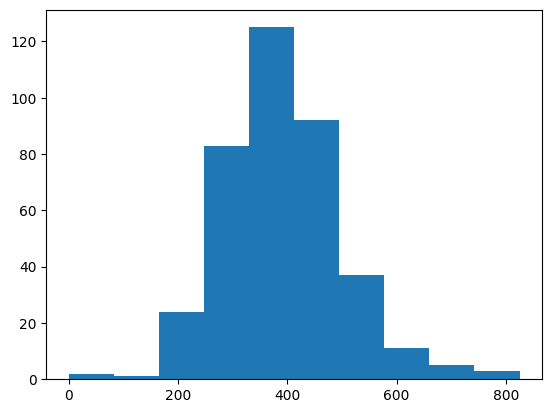

In [23]:
max_f_idx = pickle.load(open('/home/ubuntu/OSX/output/STS_test6/log/max_f_idx.p', 'rb'))
stat = []
for video in max_f_idx:
    stat.append(max_f_idx[video])
plt.hist(stat)
plt.show

#### Saliency at the video level

In [ ]:
df_calc = pd.read_csv(r'../data/dataClean_text.csv')
df_calc = df_calc.iloc[:,:537]
df_calc.drop(['X', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,n,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,...,neck_max_y_acc_stand2sit,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand
0,kGhQ1FQc,5,18.752067,-0.275275,0.27,0.631539,0.058177,5,5.972633,-1.618283,...,3.505124,1.081186,1.006474,1.221493,0.869235,0.974188,104.281728,130.765245,174.111505,170.157767
1,KyINSk8e,5,13.346667,-0.216883,0.37,0.395926,0.071269,5,4.337667,-1.101100,...,3.654509,1.057510,1.018101,0.979709,0.735422,0.949425,113.416249,122.046417,183.473800,170.403354
2,ybGzWMPA,5,9.175833,0.108442,0.54,0.152175,0.044839,5,4.304300,0.008342,...,4.730823,1.324459,1.407150,1.272274,1.064869,0.963154,110.360354,116.014708,154.888698,154.736858
3,b632WDpF,4,11.033333,0.133333,0.36,0.234965,0.031573,4,3.833333,-0.700000,...,3.772340,1.523048,1.506615,1.525126,1.145206,0.948291,359.999821,132.874089,179.434883,172.483812
4,UDXlpEgF,5,11.444767,-0.108442,0.44,0.225910,0.045701,5,4.471133,-0.600600,...,5.261429,1.017858,0.947927,0.879847,0.623896,0.993858,113.339615,115.098166,178.141457,171.161810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,tFSyXitq,5,10.066667,0.225000,0.50,0.344867,0.069775,5,4.800000,0.075000,...,4.927668,0.864066,0.852848,1.118739,0.830468,0.966577,94.484956,115.572113,176.582448,175.372981
401,OuYG4U64,5,10.477133,0.116783,0.48,0.178317,0.044853,5,4.771433,-0.150150,...,4.448819,1.151292,1.100129,1.012293,0.837304,0.965469,109.993607,106.238842,182.016620,166.714119
402,nM7tQcBS,5,5.366667,0.058333,0.93,0.082731,0.076364,5,2.633333,0.008333,...,6.866623,1.374656,1.467833,1.375480,1.147340,0.970511,92.538523,108.185109,167.608827,164.889848
403,zN0O4jLu,5,24.290933,0.075075,0.21,0.377854,0.016347,5,12.412400,0.241908,...,2.242874,0.871977,1.034409,0.565355,0.657769,0.962403,106.005854,96.882321,160.433369,152.676643


In [96]:
saliency_N = saliency.view((N, F, J, D)).mean(dim=(1, 2, 3)).cpu()
saliency_N_df = pd.DataFrame(saliency_N.numpy(), columns=["saliency"])
saliency_N_df.insert(0, 'subjectid', train_data.index)
saliency_N_df.insert(2, 'OA_check', train_data["OA_check"].reset_index(drop=True))
saliency_N_df_sorted = saliency_N_df.sort_values('saliency')
saliency_N_df_sorted = saliency_N_df_sorted.join(df_calc.set_index('subjectid'), on='subjectid')

# All OA=0 examples have 0 to negative saliency
OA_negative = saliency_N_df_sorted.loc[saliency_N_df_sorted['OA_check']==0]

# Get average performance on a few key metrics for comparison with the positive group
OA_negative_avg = OA_negative[["saliency", "OA_check", 'time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min',]].mean(axis=0)
OA_negative_avg

saliency                -2.173411e-08
OA_check                 0.000000e+00
time_sit2stand           4.602560e+00
speed_sit2stand          1.142672e+00
time_stand2sit           5.248642e+00
speed_stand2sit          8.859924e-01
trunk_lean_range_mean    2.377707e+01
trunk_lean_max           2.039120e+02
trunk_lean_min           1.740413e+02
dtype: float64

In [103]:
# All except 1 OA=1 examples have 0 to negative saliency
OA_positive = saliency_N_df_sorted.loc[saliency_N_df_sorted['OA_check']==1]
OA_positive[["subjectid", "saliency", "OA_check", 'time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min']]

,subjectid,saliency,OA_check,time_sit2stand,speed_sit2stand,time_stand2sit,speed_stand2sit,trunk_lean_range_mean,trunk_lean_max,trunk_lean_min
263,Wyg30nvk,-6.306633e-13,1,8.583333,0.58,11.566667,0.35,51.778745,228.123985,161.764845
190,dHsx22mJ,7.781596e-10,1,5.122807,0.98,12.000000,0.33,45.696993,224.262490,162.163116
164,tFbOCnVv,1.256354e-09,1,4.433333,1.13,4.633333,0.86,28.755447,212.679940,168.914717
140,bePyG1Du,6.913484e-09,1,5.438767,0.92,6.506500,0.61,21.633433,198.134596,173.669405
102,GwvQ3hpI,1.840324e-08,1,4.800000,1.04,6.266667,0.64,27.847546,205.093092,171.299196
204,YJWapbq3,2.313213e-08,1,4.700000,1.06,3.433333,1.17,27.938794,203.888094,167.550804
31,tFSyXitq,3.127447e-08,1,4.800000,1.04,3.566667,1.12,18.410144,198.479089,175.191112
79,oDGL8XpK,6.640318e-08,1,7.466667,0.67,8.133333,0.49,26.225306,215.594177,177.667816
208,MVZpHgro,7.714395e-08,1,5.083333,0.98,9.125000,0.44,30.819837,209.751834,168.752567
42,xM4HMws8,1.549719e-07,1,4.204200,1.19,3.169833,1.26,31.720091,216.725689,181.411275


In [106]:
# Examine the ratio between positive and negative groups. Data shows that saliency is highest among videos labeled as OA=1 but with key metrics fairly similar to the negative group.
OA_positive_ratio = OA_positive[:]
OA_positive_ratio["saliency"] = OA_positive['saliency']/OA_negative_avg['saliency']
OA_positive_ratio["time_sit2stand"] = OA_positive['time_sit2stand']/OA_negative_avg['time_sit2stand']
OA_positive_ratio["speed_sit2stand"] = OA_positive['speed_sit2stand']/OA_negative_avg['speed_sit2stand']
OA_positive_ratio["time_stand2sit"] = OA_positive['time_stand2sit']/OA_negative_avg['time_stand2sit']
OA_positive_ratio["speed_stand2sit"] = OA_positive['speed_stand2sit']/OA_negative_avg['speed_stand2sit']
OA_positive_ratio["trunk_lean_range_mean"] = OA_positive['trunk_lean_range_mean']/OA_negative_avg['trunk_lean_range_mean']
OA_positive_ratio["trunk_lean_max"] = OA_positive['trunk_lean_max']/OA_negative_avg['trunk_lean_max']
OA_positive_ratio["trunk_lean_min"] = OA_positive['trunk_lean_min']/OA_negative_avg['trunk_lean_min']
OA_positive_ratio[["subjectid", "saliency", "OA_check", 'time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min']]


,subjectid,saliency,OA_check,time_sit2stand,speed_sit2stand,time_stand2sit,speed_stand2sit,trunk_lean_range_mean,trunk_lean_max,trunk_lean_min
263,Wyg30nvk,0.000029,1,1.864904,0.507582,2.203745,0.395037,2.177676,1.118738,0.929462
190,dHsx22mJ,-0.035804,1,1.113034,0.857639,2.286306,0.372464,1.921894,1.099801,0.931751
164,tFbOCnVv,-0.057806,1,0.963232,0.988910,0.882768,0.970663,1.209377,1.042999,0.970544
140,bePyG1Du,-0.318094,1,1.181683,0.805131,1.239654,0.688494,0.909844,0.971667,0.997863
102,GwvQ3hpI,-0.846745,1,1.042898,0.910148,1.193960,0.722354,1.171193,1.005792,0.984244
204,YJWapbq3,-1.064324,1,1.021171,0.927650,0.654137,1.320553,1.175031,0.999883,0.962707
31,tFSyXitq,-1.438958,1,1.042898,0.910148,0.679541,1.264119,0.774282,0.973357,1.006606
79,oDGL8XpK,-3.055252,1,1.622286,0.586345,1.549607,0.553052,1.102966,1.057290,1.020837
208,MVZpHgro,-3.549442,1,1.104458,0.857639,1.738545,0.496618,1.296200,1.028639,0.969612
42,xM4HMws8,-7.130355,1,0.913448,1.041419,0.603934,1.422134,1.334062,1.062839,1.042346
